In [12]:
import pandas as pd
import statsmodels
import matplotlib.pyplot as plt
import math
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fftpack import fft
import random
from random import randrange
random.seed(1)

In [13]:
x_axis = np.arange(0, 29-1/288, 1/288).tolist()
np_cpu = np.load("wetransfer-2ee104//google-cpu-full.npy")

# full_cpu is a list of pandas series of the cpu utilisation of all machines
# just a lazy way of converting nd-arrays to pd-series
full_cpu = []
for x in range (0,len(np_cpu)):
    full_cpu.append(pd.Series(np_cpu[x], index = x_axis))  

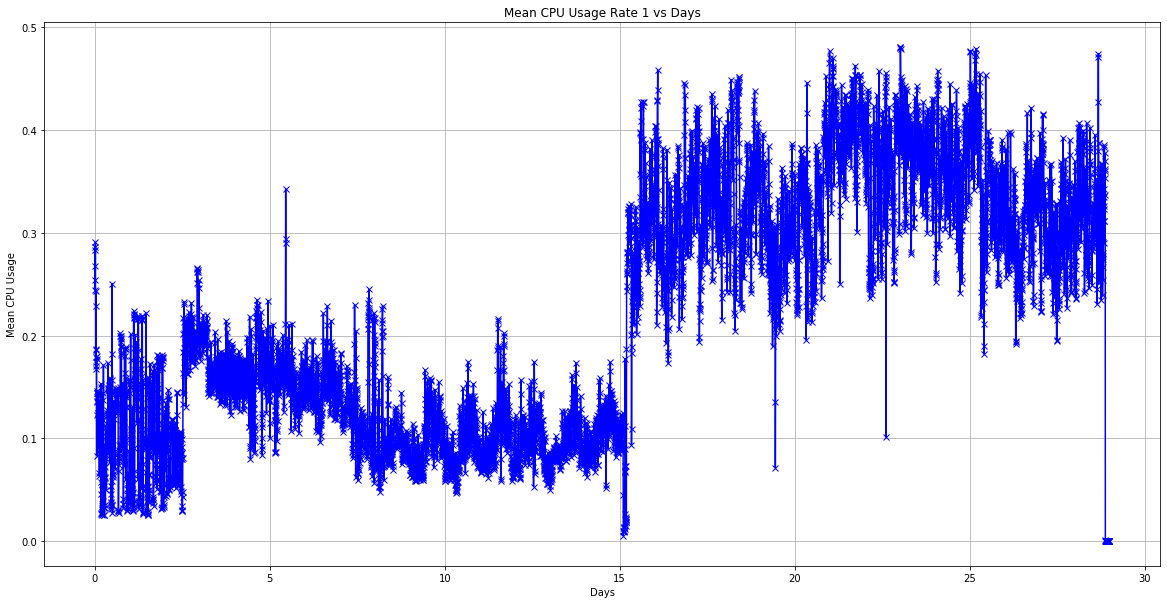

In [39]:
plt.figure(figsize=(20,10))
plt.plot(x_axis,full_cpu[0], color = 'blue', marker = "x")  
plt.title("Mean CPU Usage Rate 1 vs Days")  
plt.xlabel("Days")  
plt.ylabel("Mean CPU Usage")  
plt.grid()
plt.show()

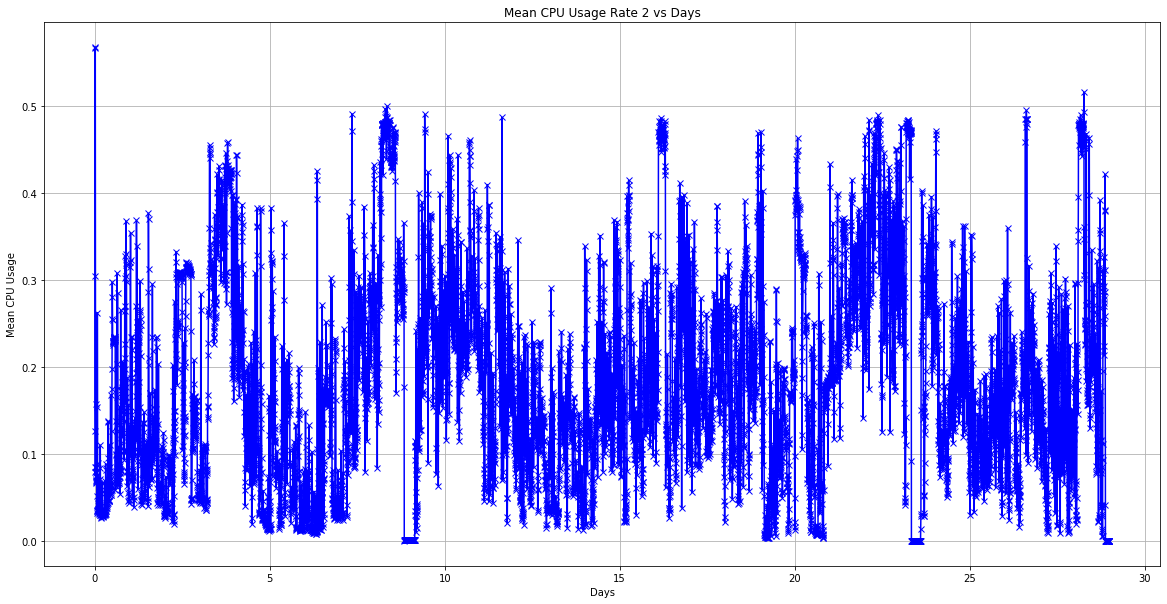

In [40]:
plt.figure(figsize=(20,10))
plt.plot(x_axis,full_cpu[1], color = 'blue', marker = "x")  
plt.title("Mean CPU Usage Rate 2 vs Days")  
plt.xlabel("Days")  
plt.ylabel("Mean CPU Usage")  
plt.grid()
plt.show()

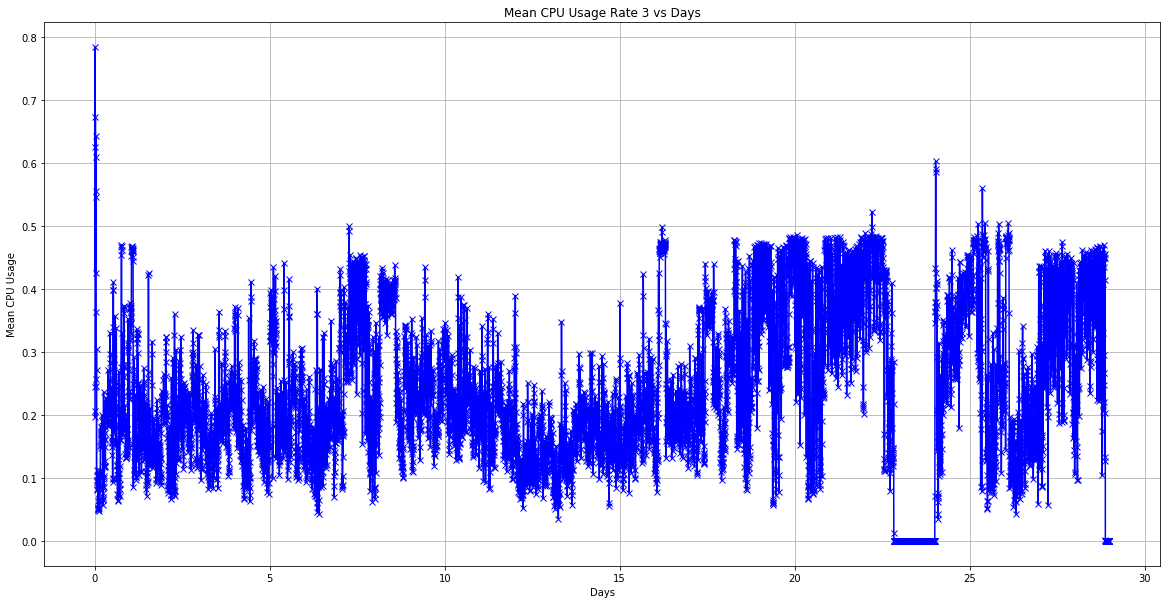

In [41]:
plt.figure(figsize=(20,10))
plt.plot(x_axis,full_cpu[2], color = 'blue', marker = "x")  
plt.title("Mean CPU Usage Rate 3 vs Days")  
plt.xlabel("Days")  
plt.ylabel("Mean CPU Usage")  
plt.grid()
plt.show()

## Stationarity

- Does the data have the same statistical property (Variance, Mean, Autocorrelation) throughout the whole series.
- Most analytics procedure in time-series analysis require data to be stationary or at least the procedure itself i.e. the model function will make the data stationary during the model setup.
- If the data is not stationary, there are transformations that can be used to make the data stationary.

### Differencing: 
- Adjust data according to the time spent that differ in variance or mean. Make the statistics the same throughout the whole series.
- Used extensively in ARIMA models

### Augmented Dicky-Fuller Test:
- Test for stationarity
- Removes autocorrelation and then tests for non-statinarity
- Focuses on equal mean and equal variance though the entire series
- Null hypothesis, h0 = The series is non-stationary
- The more negative the test, the stronger the rejection of H0
- Take stationarity: p-value < 0.05

In [1]:
def stationarity_test(timeseries, info = False):
    '''Augmented Dickey-Fuller test for stationarity'''
    from statsmodels.tsa.stattools import adfuller
    df_test = adfuller(timeseries, autolag = "AIC")
    df_list = [df_test[0],df_test[1]<0.05,df_test[1],df_test[2],df_test[3]]
    df_output = pd.Series(df_list, index = ["Test Statistic", 
                                              "Stationarity",
                                              "p-value", 
                                              "Number of Lags Used",
                                              "Number of Observations Used"
                                             ])
    
    if(info):
        print("Results of Dickey-Fuller Test:")
        print(df_output)
        
    return df_output

def bulk_stationarity(timeseries, number_of_samples = 10):
    '''
    - takes in a list of timeseries
    - randomly chooses number_of_samples of timeseries
    - outputs a df detailing if the timeseries is stationary
    '''
    
    from random import randrange
    random_number = []
    for x in range(0,number_of_samples):
        random_number.append(randrange(len(full_cpu)))

    random_number = np.sort(random_number) 

    stationarity_list = []
    for x in random_number:
        stationarity_list.append(stationarity_test(full_cpu[x]))
    df_output = pd.DataFrame(stationarity_list, columns = ["Test Statistic", 
                                              "Stationarity",
                                              "p-value", 
                                              "Number of Lags Used",
                                              "Number of Observations Used"
                                             ], index = random_number)    
    return df_output

In [146]:
# Randomly choose about 2% of the timeseries to check if they are stationary
stationarity_of_120 = bulk_stationarity(full_cpu, number_of_samples = 240)

In [147]:
stationarity_of_120['Stationarity'].value_counts()

True     239
False      1
Name: Stationarity, dtype: int64

### Stationarity of Dataset
2% of the timeseries are chosen at random and are tested on their stationarity using the Augmented Dicky-Fuller test. Out of the 2% chosen, 0.416667% are non-stationary. It is hence estimated that 99.6% of all of the timeseries are stationary which is equivalent to 12424 out of 12476 timeseries

In [151]:
len(full_cpu)

12476

## ACF and PACF Plot
- Gives the correlation between different lags
- PACF is adjusted for all earlier lags


In [3]:
def plot_autocorrelation(timeseries):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    fig, (ax1, ax2) = plt.subplots(2,1,figsize = (20,8))
    ax1.grid()
    ax2.grid()
    plot_acf(timeseries, lags = 20, ax=ax1)
    plot_pacf(timeseries, lags = 20, ax = ax2)

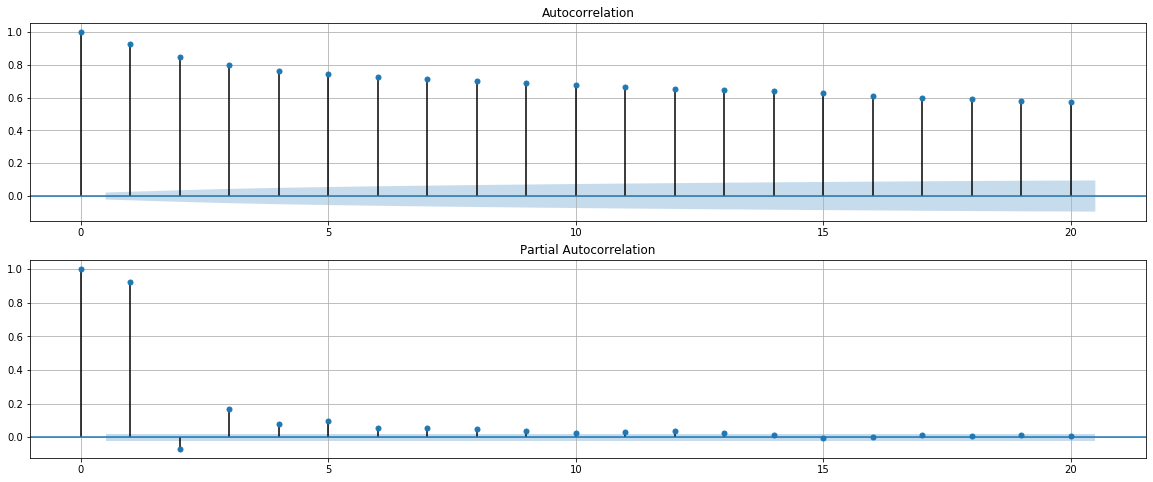

In [11]:
plot_autocorrelation(full_cpu[5])

In [137]:
def decompose(timeseries, bar_f = 288, sub_plot = False, plot_single = False):
    import statsmodels.api as sm
    timeseries_stl = sm.tsa.seasonal_decompose(timeseries, freq = bar_f)
    
    if(sub_plot):
        fog, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (20,20))
        timeseries.plot(ax = ax1)
        timeseries_stl.trend.plot(ax = ax2)
        timeseries_stl.seasonal.plot(ax = ax3)
        timeseries_stl.resid.plot(ax = ax4)
        ax1.grid()
        ax2.grid()
        ax3.grid()
        ax4.grid()
        ax1.set_title("Timeseries")
        ax2.set_title("Trend")
        ax3.set_title("Seasonality")
        ax4.set_title("Residuals")
        plt.tight_layout()
        
    if(plot_single):
        plt.figure(figsize=(20,10))
        plt.plot(x_axis,timeseries_stl.trend, color = 'blue', label = "Trend") 
        plt.plot(x_axis,timeseries_stl.seasonal, color = 'red', label = "Seasonal") 
        plt.plot(x_axis,timeseries_stl.resid, color = 'green', label = "Residual") 
        plt.title("Decomposition vs Days")  
        plt.xlabel("Days")  
        plt.ylabel("Decomposed Time Series")  
        plt.legend()
        plt.grid()
        plt.show()
        
    return timeseries_stl    

Random Number:  9048


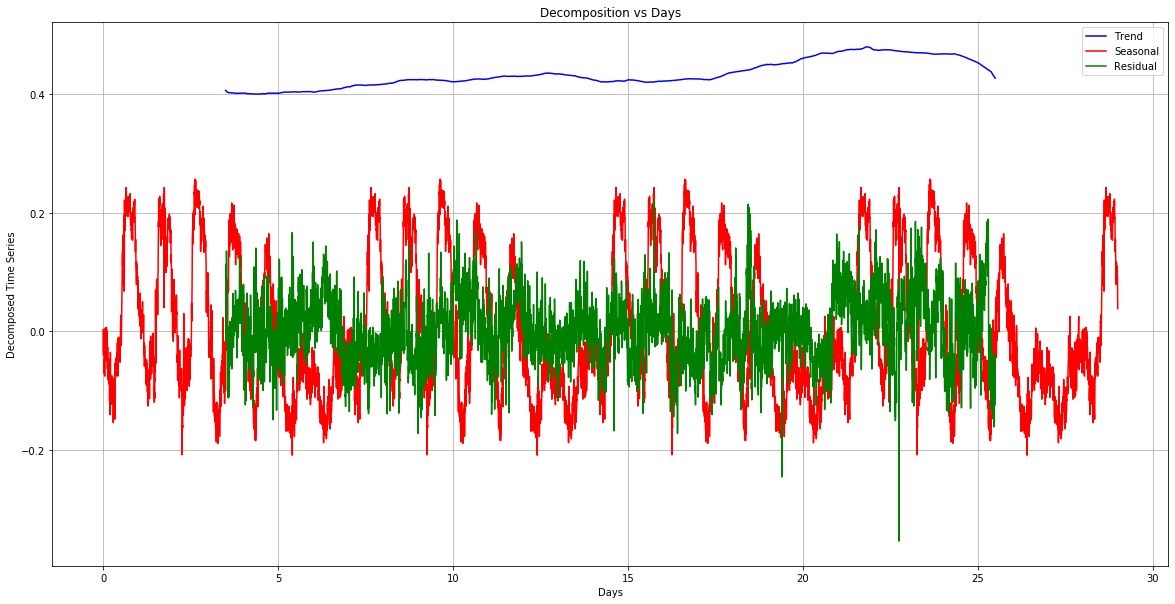

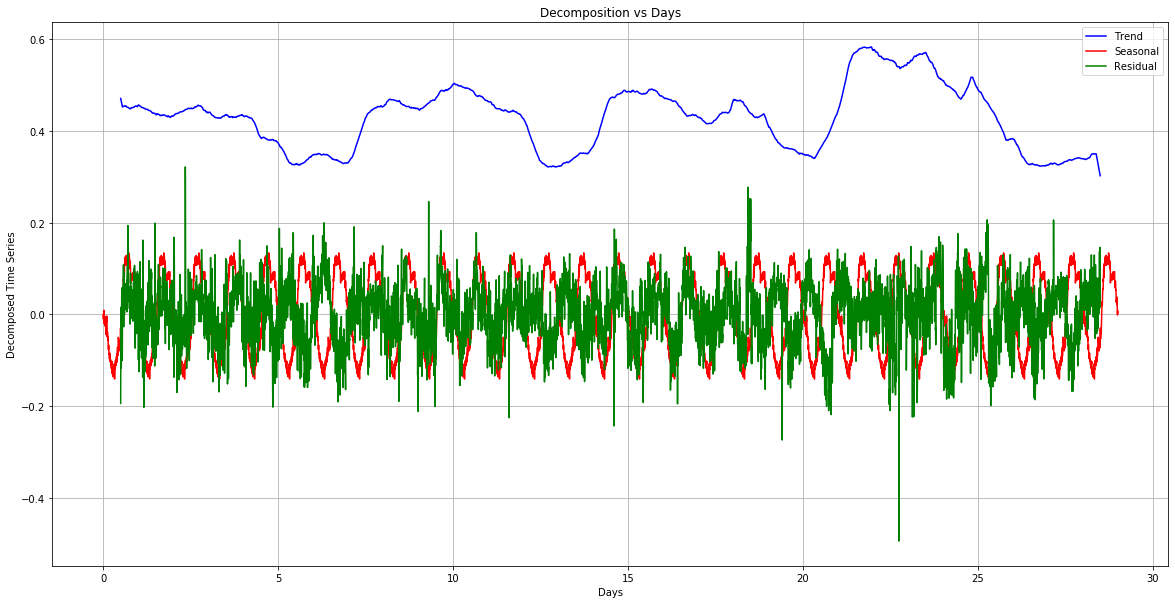

In [94]:
from random import randrange
rand = randrange(len(full_cpu))
print("Random Number: ", rand)
decompose(full_cpu[rand], plot_single = True, bar_f = 288*7)
decompose(full_cpu[rand], plot_single = True, bar_f = 288)

Random Number:  5641


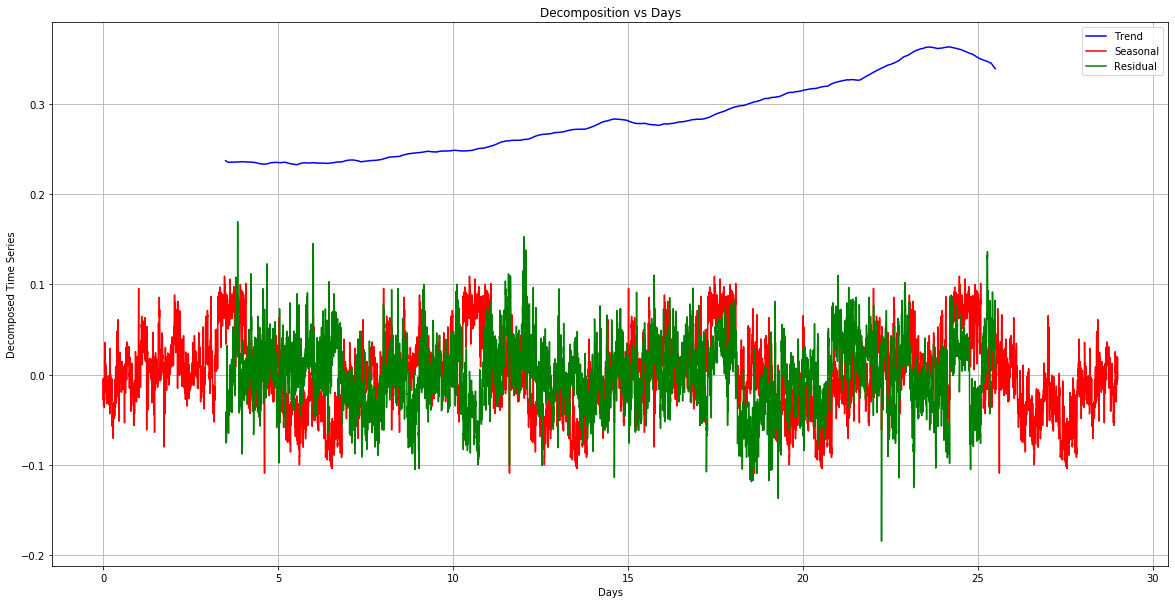

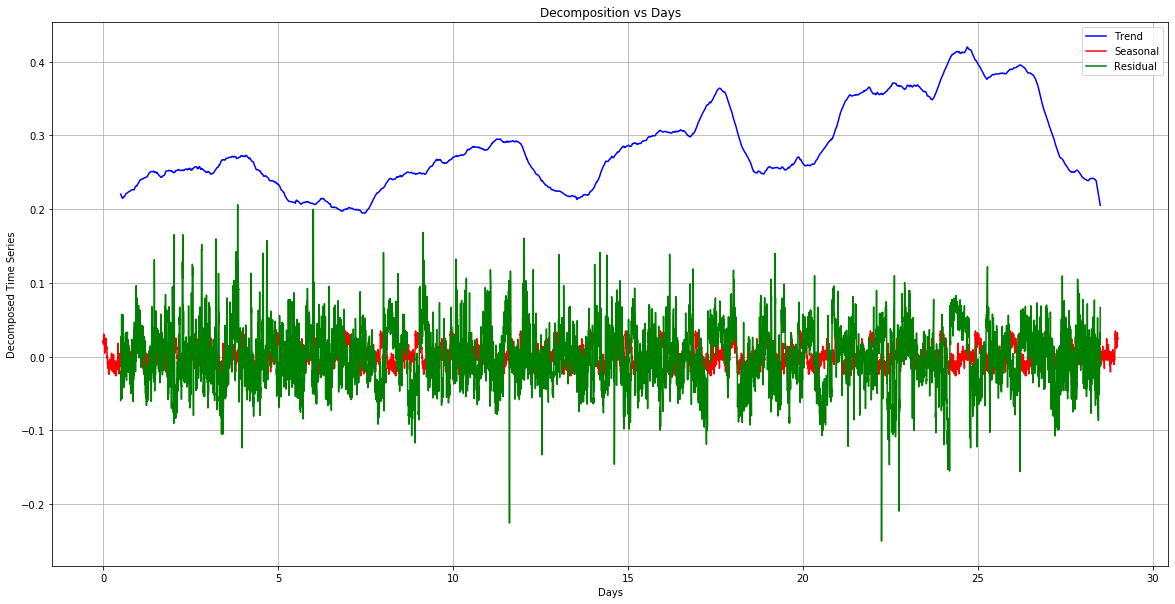

In [95]:
from random import randrange
rand = randrange(len(full_cpu))
print("Random Number: ", rand)
decompose(full_cpu[rand], plot_single = True, bar_f = 288*7)
decompose(full_cpu[rand], plot_single = True, bar_f = 288)

Random Number:  8038


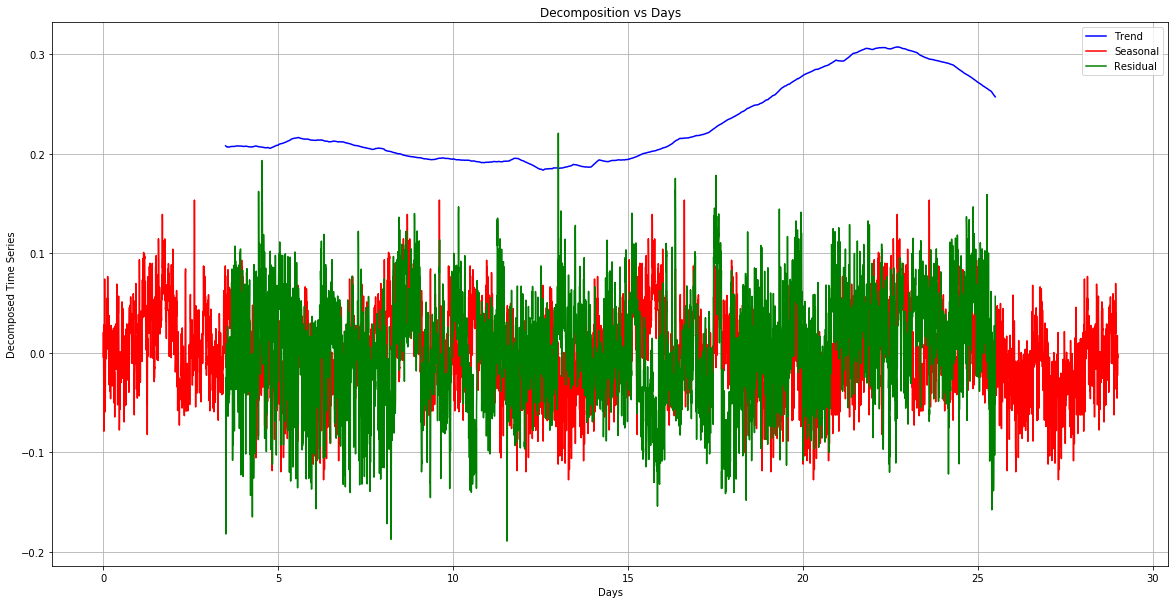

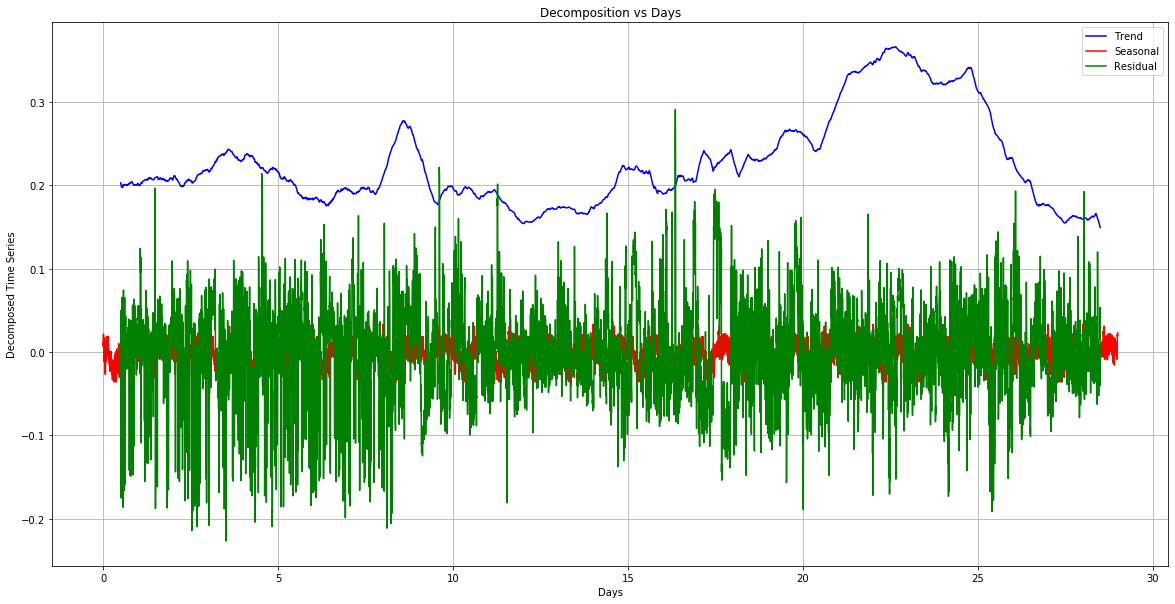

In [96]:
from random import randrange
rand = randrange(len(full_cpu))
print("Random Number: ", rand)
decompose(full_cpu[rand], plot_single = True, bar_f = 288*7)
decompose(full_cpu[rand], plot_single = True, bar_f = 288)

In [140]:
# to compare the power of each of the component, we can look at their respective variances

def compare_variance(timeseries_list, number_of_samples):
    
    import statsmodels.api as sm
    from random import randrange
    
    random_number = []
    for x in range(0,number_of_samples):
        random_number.append(randrange(len(full_cpu)))

    headers = ["Days Seasonal Absolute Mean", 
                                 "Days Residual Absolute Mean",
                                 "Weeks Seasonal Absolute Mean",
                                 "Weeks Residual Absolute Mean"]
    random_number = np.sort(random_number)
    temp_list = []
    
    for x in random_number:
        decompose_day = decompose(timeseries_list[x], bar_f = 288)
        decompose_week = decompose(timeseries_list[x], bar_f = 288*7)
        temp_list.append([decompose_day.seasonal.abs().mean(), 
                   decompose_day.resid.abs().mean(), 
                   decompose_week.seasonal.abs().mean(),
                   decompose_week.resid.abs().mean()
                  ])
    df = pd.DataFrame(temp_list, columns = headers, index = random_number)    
        
    return df

In [142]:
compare_variance(full_cpu, 10)

,Days Seasonal Absolute Mean,Days Residual Absolute Mean,Weeks Seasonal Absolute Mean,Weeks Residual Absolute Mean
423,0.008803,0.058614,0.048007,0.055345
2412,0.016953,0.058638,0.058232,0.058614
3659,0.013352,0.036803,0.031578,0.037572
3972,0.010161,0.055908,0.052102,0.053302
6032,0.015693,0.074551,0.049509,0.069621
8556,0.009075,0.055706,0.041047,0.047159
9132,0.048446,0.060764,0.081873,0.054469
10017,0.012617,0.042046,0.033360,0.040944
10982,0.011295,0.049523,0.030528,0.043807
12382,0.012258,0.051218,0.044979,0.053570
